# Introduction to Machine Learning with PyTorch
## Project: Finding Donors for *CharityML*

## Introduction

In this project, I build and evaluate supervised learning models to predict whether an individual’s annual income exceeds $50K using demographic and employment-related attributes from the 1994 U.S. Census. The goal is a practical binary classifier that could support donor outreach decisions (e.g., prioritizing contacts or tailoring donation requests) in nonprofit fundraising scenarios.

I compare multiple candidate algorithms, select the strongest performer based on validation results, and then tune it to improve generalization. I also include a brief discussion of trade-offs (performance vs. interpretability) and error patterns to make the model’s behavior easier to reason about.

**Data source:** The dataset is based on the Census Income (Adult) dataset from the UCI Machine Learning Repository (donated by Ron Kohavi and Barry Becker). The version used here applies minor cleaning/preprocessing compared to the original (e.g., removing ill-formatted/missing entries and excluding the fnlwgt feature). 

[UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income)

----
## Exploring the Data
 In this section, I load the Census Income dataset and perform a quick sanity-check to understand what I’m working with. Each row corresponds to an individual described by a mix of demographic and employment-related attributes. The prediction target is the `income` column, indicating whether a person earns more than `$50,000` per year or `$50,000` or less. All remaining columns are treated as input features.

**Target Variable:**
The `income` column transforms this problem into a *binary classification task*. A positive class (>50K) indicates potential donors, while the negative class (<=50K) corresponds to individuals unlikely to contribute.

**Features:**
The dataset includes both *categorical variables (e.g., education level, occupation, marital status)* and *numerical variables (e.g., age, hours worked per week, capital gain/loss)*.

Because of this mixed feature space, preprocessing typically involves:

- Scaling/normalization for numerical values (depending on the chosen model)

- Encoding categorical variables (commonly one-hot encoding) to make them usable by standard ML algorithms

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Display the first record
display(data.head(n=1))

# Display first five records
#display(data.head())

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


### Implementation: Data Exploration
An initial analysis is performed to quantify the class distribution of the target label `income`(how many individuals fit into either group). The following summary statistics are computed:

- The total number of records, `n_records`
- The number of individuals earning more than `$50,000` annually, `n_greater_50k`.
- The number of individuals earning at most `$50,000` annually, `n_at_most_50k`.
- The percentage of individuals earning more than `$50,000` annually, `greater_percent`.

This baseline is used to detect potential class imbalance and to guide evaluation. If the positive class is *underrepresented*, relying on accuracy alone can be misleading, so additional metrics (precision/recall and F_β) are included during model comparison.

In [2]:
# Total number of records
n_records = data.shape[0]

# Number of records where individual's income is more than $50,000
n_greater_50k = (data['income']  == ">50K").sum()

# Number of records where individual's income is at most $50,000
n_at_most_50k = (data['income'] == "<=50K").sum()


# Percentage of individuals whose income is more than $50,000
greater_percent = (n_greater_50k / n_records) * 100

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78439697492371%


**Feature-Set Exploration**

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

----
## Preparing the Data
Before model training, the dataset is prepared through preprocessing, where features are formatted and transformed into a model-ready representation. In this version of the data, no missing or invalid entries are present; however, several feature characteristics still require adjustment to ensure consistent inputs and reliable learning behavior. These preprocessing steps typically have a measurable impact on downstream model performance.

Machine learning algorithms generally expect **numerical**, **normalized**, and **consistent** inputs. Raw datasets often contain:

- Categorical strings (e.g., `male`, `female`, `private`, `self-emp`)

- Skewed numerical features (e.g., `hours-per-week` might have extreme outliers)

- Imbalanced feature scales (e.g., **age** ranges `17–90`, while **education_num** ranges `1–16`)

If not adjusted, these can hurt performance (especially for algorithms based on distance metrics, like *SVM* or *k-NN*, and *gradient-based models*).

### Transforming Skewed Continuous Features
Skewed, long-tailed feature distributions are present in many real-world datasets and can lead to unstable learning dynamics when extreme values dominate the feature scale. In the Census dataset, this pattern is observed in `capital-gain` and `capital-loss`. Histogram inspection shows that most samples are concentrated near zero, while a small fraction contains very large values, resulting in strong skew. To reduce the influence of these extreme values and make subsequent scaling/normalization more effective, a log-based transformation is applied prior to model training.

C:\Users\Asus\NN_Projects\MachineLearningProjects\FindingDonors\visuals.py:50: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


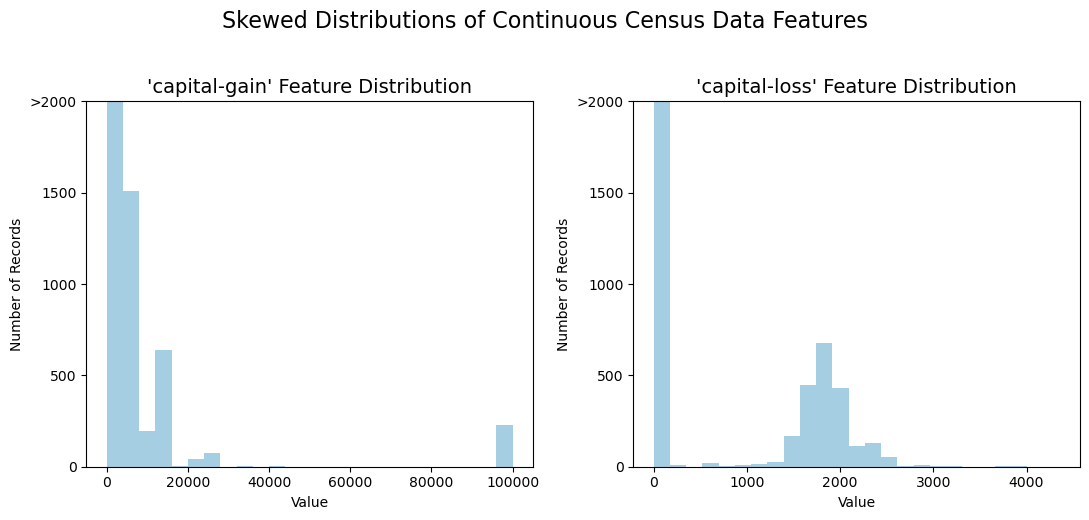

In [3]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

### Reasoning Behind Transformation

**Model Sensitivity:** Algorithms such as logistic regression, SVMs, and neural networks are highly sensitive to feature scale. Skewed distributions can bias learning towards the minority of extreme values.

**Improved Interpretability:** Transforming features (e.g., using a logarithmic transformation) reduces skew and brings values closer to a normal-like distribution, making the learning process more stable.

*Since `log(0)` is undefined, it is common to apply a `log(x + 1)` transformation, ensuring that zero-valued entries are preserved without introducing errors.*

For highly-skewed feature distributions such as `capital-gain` and `capital-loss`, it is common practice to apply a [logarithmic transformation](https://en.wikipedia.org/wiki/Data_transformation_(statistics)) on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers.

C:\Users\Asus\NN_Projects\MachineLearningProjects\FindingDonors\visuals.py:50: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


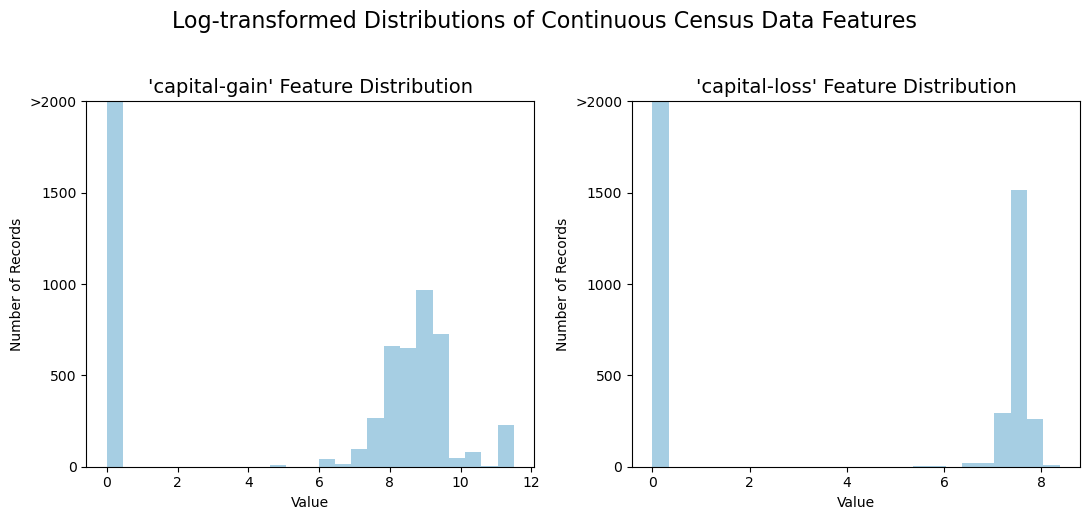

In [4]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']

# features_raw verisinin bir kopyasını al dönüşüm orjinal veriyi bozmasın
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

'''
--> Alternative_1:

for col in skewed:
    features_log_transformed[col] = np.log(features_raw[col] + 1)

--> Alternative_2:

features_log_transformed[skewed] = np.log(features_raw[skewed] + 1)
   
'''

# Visualize the new log distributions
vs.distribution(features_log_transformed, transformed = True)

### Normalizing Numerical Features  

After transformations are applied to skewed features, it is often considered good practice to perform **scaling** on all numerical features. Scaling ensures that each numerical attribute contributes equally during model training, rather than allowing features with naturally larger ranges to dominate the learning process.  

Unlike transformations (e.g., logarithmic adjustment), scaling does **not alter the overall shape of the feature distribution**. Instead, the values are rescaled to fall within a standardized range. This ensures that algorithms relying on **distance metrics or gradient-based optimization** (e.g., KNN, SVM, logistic regression, neural networks) perform more effectively.  

For this project, [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) is employed. 

This method scales each numerical feature into a **fixed range between 0 and 1** according to the formula:  

$
x' = \frac{x - x_{\min}}{x_{\max} - x_{\min}}
$

where: 
- $x$ : original value 
- $x_{\min}$ : minimum values of the feature 
- $x_{\max}$ : maximum values of the feature 
- $x'$ : the normalized result 

---

#### Practical Considerations  

- **Why Min-Max Scaling?**  
  - Retains the original distribution shape while ensuring features are bounded in a uniform scale.  
  - Especially useful for algorithms sensitive to magnitude differences (e.g., neural networks).  

- **Alternative Approaches:**  
  - **StandardScaler (Z-score normalization):** Centers features at mean 0 with unit variance, often used for algorithms assuming Gaussian distributions.  
  - **RobustScaler:** Reduces the effect of outliers by using median and interquartile range.  

- **Interpretability Note:**  
  Once normalization is applied, the scaled data no longer represents the original magnitudes (e.g., income, age, or hours per week). However, this trade-off ensures improved comparability across features during training.  

---

After scaling, the normalized dataset is ready for use in model training pipelines, where each feature is equally weighted during learning.  


In [5]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


### Implementation: Data Preprocessing  

From the table presented in **Exploring the Data**, it can be observed that several features for each record are non-numeric. Since most machine learning algorithms expect **numerical inputs**, these non-numeric features (referred to as *categorical variables*) must be converted before training.  

One common technique for this conversion is **one-hot encoding**, which creates a separate binary variable for each possible category of a categorical feature. For instance, assume that the feature `someFeature` has three possible values: `A`, `B`, and `C`.  

|   | someFeature |                    
| :-: | :-: |                            
| 0 |  B  |  
| 1 |  C  |
| 2 |  A  |  

After one-hot encoding, this feature is transformed into three binary features: `someFeature_A`, `someFeature_B`, and `someFeature_C`.  

|| someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: | :-: | :-: |
| 0 | 0 | 1 | 0 |
| 1 | 0 | 0 | 1 |
| 2 | 1 | 0 | 0 |  

This encoding ensures that categorical features are expressed numerically without implying any ordinal relationship among the categories.  

---

#### Target Label Encoding  

In addition to the features, the **target label `income`** is also non-numeric and requires conversion. Since only two categories exist (`"<=50K"` and `">50K"`), one-hot encoding is unnecessary. Instead, a **binary mapping** can be used:  

- `<=50K` → **0**  
- `>50K` → **1**  

This transformation simplifies the problem into a **binary classification task**, where the positive class (`1`) represents individuals more likely to be donors.  

---

In [6]:
# One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
features_final = pd.get_dummies(features_log_minmax_transform)

# Encode the 'income_raw' data to numerical values
income = income_raw.map({ "<=50K": 0, ">50K": 1 })

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

# Uncomment the following line to see the encoded feature names
print(encoded)

103 total features after one-hot encoding.
['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'education_level_ 10th', 'education_level_ 11th', 'education_level_ 12th', 'education_level_ 1st-4th', 'education_level_ 5th-6th', 'education_level_ 7th-8th', 'education_level_ 9th', 'education_level_ Assoc-acdm', 'education_level_ Assoc-voc', 'education_level_ Bachelors', 'education_level_ Doctorate', 'education_level_ HS-grad', 'education_level_ Masters', 'education_level_ Preschool', 'education_level_ Prof-school', 'education_level_ Some-college', 'marital-status_ Divorced', 'marital-status_ Married-AF-spouse', 'marital-status_ Married-civ-spouse', 'marital-status_ Married-spouse-absent', 'marital-status_ Never-married', 'marital-status_ Separated', 'marital-status_ Widowed', 'occupation_ A

### Shuffle and Split Data  

At this stage, all categorical variables have been successfully converted into numerical features, and the numerical features have been normalized. With preprocessing complete, the dataset is now ready to be divided into **training and testing sets**.  

This division is essential for evaluating model performance:  
- **Training set (80%)**: Used by the learning algorithms to fit parameters and patterns.  
- **Testing set (20%)**: Held out from training and used to evaluate how well the model generalizes to unseen data.  

By splitting the dataset in this way, the risk of overfitting is reduced, since performance is not assessed on the same data used for training.  

---

In [7]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


----
## Evaluating Model Performance

In this section, four different algorithms will be investigated to determine which provides the most effective model of the data.  

- **Three algorithms** will be selected from among common supervised learning approaches. These will be trained, evaluated, and compared in terms of performance and efficiency.  
- **One algorithm** will serve as a *naïve predictor*, which acts as a simple baseline for performance comparison.  

---

#### Why Use a Naïve Predictor?  
A naïve predictor is a deliberately simplistic model (e.g., always predicting the majority class). Although it has no practical predictive power, it provides a **baseline benchmark**. Any supervised learner that cannot surpass this baseline should be considered ineffective for the task.  

For example:  
- If the dataset contains 75% of individuals earning `<=50K`, then a naïve predictor that always predicts "`<=50K`" would achieve 75% accuracy.  
- While this appears strong at first glance, it would completely fail to identify potential donors (`>50K`).  

By comparing more sophisticated algorithms against the naïve predictor, it becomes possible to quantify the **true value of machine learning models**. 


---

### Metrics and the Naive Predictor  

*CharityML* has observed that individuals earning more than `$50,000` are the most likely to donate. Because of this, the evaluation of models must focus on identifying these individuals as accurately as possible.  

At first glance, **accuracy** might appear to be an appropriate metric. However, accuracy alone can be misleading in the presence of **class imbalance**. Since the majority of individuals earn at most `$50,000`, a classifier could achieve high accuracy by simply predicting "`<=50K`" for everyone yet such a model would completely fail to identify potential donors.  

---

#### Importance of Precision Over Recall  

For *CharityML*, predicting that someone earns more than `$50,000` when in reality they do not (a false positive) is highly detrimental. It would mean wasting resources by sending letters to non-donors.  

Therefore, **precision** is considered more important than recall in this context. A model that precisely identifies individuals likely to earn above `$50,000` provides greater value than one that broadly casts a net but captures many false positives.  

To balance **precision** and **recall**, the **F-beta score** is used:  

$
F_{\beta} = (1 + \beta^2) \cdot \frac{\text{precision} \cdot \text{recall}}{(\beta^2 \cdot \text{precision}) + \text{recall}}
$

In particular, when $\beta = 0.5$, **greater emphasis is placed on precision**. This metric is known as the $F_{0.5}$ score (or simply the F-score).  

---

#### Naive Predictor as a Baseline  

A **naïve predictor** establishes the simplest possible baseline for comparison. In this case, if every individual were predicted as earning "`<=50K`", then:  
- Accuracy would appear deceptively high due to class imbalance.  
- Precision and recall for the "`>50K`" class would be **zero**, since no high-income individuals would ever be predicted.  

This naïve predictor provides a benchmark. Any supervised model must outperform this trivial baseline to be considered useful.  

---

#### Recap of Key Metrics  

- **Accuracy**  
  Measures how often the classifier makes the correct prediction. It’s the ratio of the    number of correct predictions to the total number of predictions (the number of test data points)

  $$\text{Accuracy} = \frac{\text{Correct Predictions}}{\text{Total Predictions}}$$  

- **Precision**  
  Ratio of true positives to all predicted positives.  

  $$\text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}$$  

- **Recall (Sensitivity)**  
  Ratio of true positives to all actual positives.  

  $$\text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}$$  
---

#### Why F-Score?  

For imbalanced classification problems, accuracy is insufficient. Precision and recall provide deeper insights, but focusing on one while ignoring the other may be misleading.  

By using the **F-score**, the **harmonic mean** of precision and recall is calculated, providing a single metric that balances both. When $\beta = 1$, this is known as the **F1-score**. When $\beta < 1$, precision is weighted more heavily (as in *CharityML’s* case).  

$$
F_1 = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$$


The F-score ranges between 0 and 1, with higher values indicating better balance between precision and recall.  

### Question 1 - Naive Predictor Performace
* If we chose a model that always predicted an individual made more than $50,000, what would  that model's accuracy and F-score be on this dataset?

**Note** that the purpose of generating a naive predictor is simply to show what a base model without any intelligence would look like. In the real world, ideally our base model would be either the results of a previous model. When there is no benchmark model set, getting a result better than random choice is a place we could start from.

**Important** 

* When we have a model that always predicts 1 (i.e., the individual makes more than 50k) then our model will have no True Negatives (TN) or False Negatives (FN) as we are not making any negative (0 value) predictions. Therefore our Accuracy in this case becomes the same as our Precision (True Positives / (True Positives + False Positives)) as every prediction that we have made with value 1 that should have 0 becomes a False Positive; therefore our denominator in this case is the total number of records we have in total. 
* Our Recall score (True Positives / (True Positives + False Negatives)) in this setting becomes 1 as we have no False Negatives.

In [8]:
TP = np.sum(income) # Counting the ones as this is the naive case. Note that 'income' is the 'income_raw' data encoded to numerical values done in the data preprocessing step.
FP = income.count() - TP # Specific to the naive case

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case

# Calculate accuracy, precision and recall
accuracy = (TP + TN) / (TP + TN + FP + FN)
recall = TP / (TP + FN)
precision = TP / (TP + FP)

# Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
fscore = 1 + np.power(0.5, 2) 

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.2478, F-score: 1.2500]


###  Supervised Learning Models
**The following are some of the supervised learning models that are currently available in** [scikit-learn](http://scikit-learn.org/stable/supervised_learning.html) **that we may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
Listing three of the supervised learning models above that are appropriate for this problem that we will test on the census data.

**Answer:**

**Gaussian Naive Bayes (GaussianNB)**
- Gaussian Naive Bayes usage is common in spam filtering tasks. Therefore, the goal is predicting whether an email is spam or not using word frequency distributions such as Bag of Words. This algorithm is probabilistic based and it's very fast in training and prediction, works well when working with high dimensional data and it is robust even with small training sets. However, because of it's working mechanism the algorithm has a strong assumption which is features are conditionally independent given the class, this approach is often unrealistic and performs poorly when the features are highly correlated. Concerning the CharityML problem income prediction involves correlated features like education, occupation, capital-gain, Naive Bayes algorithm may oversimplify the problem and it might let us end up with high bias. It can still a good baseline model to benchmark speed and accuracy but it's not the best option.

**Ensemble Methods**
- Ensemble methods are useful in fraud detection systems, they combine bunch of weak learners to end up with a strong learner to improve accuracy and robustness. This approach typically outperform single models like decision trees and they are effective to pinpoint two main variables in ML tasks such as variance and bias. In order to reduce variance Bagging, Random Forest can be used and to reduce bias Boosting can be a good candidate. Ensemble methods are flexible and offers high predictive power. However, their structure makes them less interpretable and training can be slower and may require more computational resources. Regarding CharityML problem since the income classification is a complex task ensemble models can handle this well especially Random Forest and Gradient Boosting. So, it's a very strong candidate for this task.

**K-Nearest Neighbors (KNN)**
- KNN is used in product recommendation tasks to find customers similar to each other and suggesting what they may like based on the created groups. This algorithm is simple and naturally handles non-linear decision boundaries but prediction is slow on large datasets and performance of the model drops in high dimensional data. In CharityML problem we are working with 36177 training samples and we have many features so KNN would be computationally expensive. Therefore, this algorithm is not the best choice for our task.

### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model we've chosen, it's important that we create a training and predicting pipeline that allows us to quickly and effectively train models using various sizes of training data and perform predictions on the testing data.
In the code block below, we will implement the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
   - Make sure to set the `beta` parameter.

In [9]:
# Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score, accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end - start
        
    # Get the predictions on the test set(X_test),
    # then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # TODO: Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # TODO: Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta = 0.5)
        
    # TODO: Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, beta = 0.5)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation
In the code cell, we will implement the following:
- Import the three supervised learning models we've discussed in the previous section.
- Initialize the three models and store them in `clf_A`, `clf_B`, and `clf_C`.
  - Use a `random_state` for each model we use, if provided.
  - **Note:** Use the default settings for each model — we will tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `samples_1`, `samples_10`, and `samples_100` respectively.

GaussianNB trained on 361 samples.
GaussianNB trained on 3617 samples.
GaussianNB trained on 36177 samples.
RandomForestClassifier trained on 361 samples.
RandomForestClassifier trained on 3617 samples.
RandomForestClassifier trained on 36177 samples.
KNeighborsClassifier trained on 361 samples.
KNeighborsClassifier trained on 3617 samples.
KNeighborsClassifier trained on 36177 samples.


C:\Users\Asus\NN_Projects\MachineLearningProjects\FindingDonors\visuals.py:122: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  pl.tight_layout()


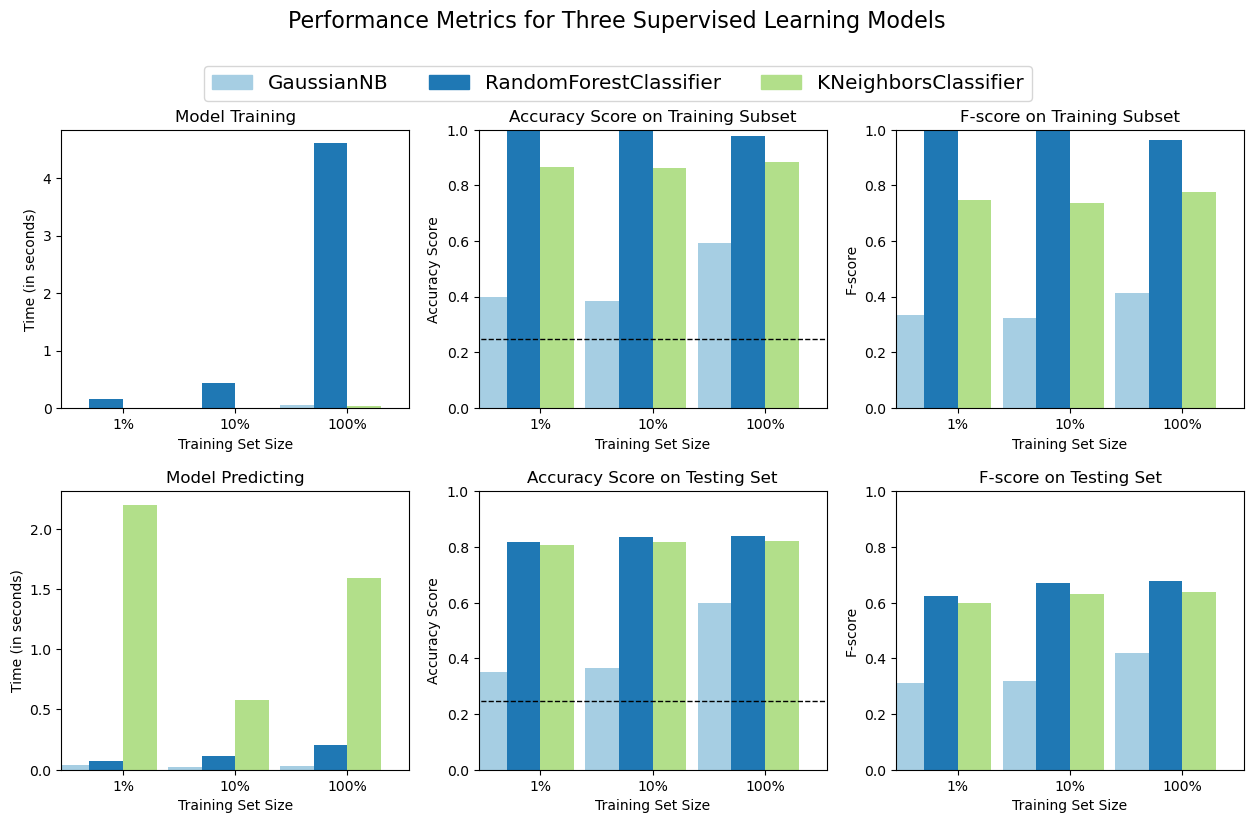

In [10]:
# Import the three supervised learning models from sklearn

from sklearn.naive_bayes import GaussianNB

from sklearn.ensemble import RandomForestClassifier

from sklearn.neighbors import KNeighborsClassifier

# Initialize the three models
clf_A = GaussianNB()
clf_B = RandomForestClassifier()
clf_C = KNeighborsClassifier()

# Calculate the number of samples for 1%, 10%, and 100% of the training data
# samples_100 is the entire training set i.e. len(y_train)
# samples_10 is 10% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
# samples_1 is 1% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
samples_100 = len(y_train)
samples_10 = int(0.1 * samples_100)
samples_1 = int(0.01 * samples_100)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

----
## Improving Results
In this final section, we will choose from the three supervised learning models the *best* model to use on the student data. We will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

### Question 3 - Choosing the Best Model

After evaluating the three models, the RandomForestClassifier looks the most appropriate choice for this task. When using 100% of the training data, it achieved the highest F-score on the testing set (around 0.68), outperforming both KNN (around 0.64) and GaussianNB (around 0.30). F-score balances precision and recall, the result indicates that Random Forest ensemble method is not only good at indentifying high income indivuals but also reduces the number of false postives, so it reduces the number of incorrectly classified as high income individuals. This makes it well suited for targeting potential donors.

In terms of runtime, Random Forest requires more training time compared to GaussianNB, but prediction remains efficient, unlike KNN which becomes computationally expensive during inference. Furthermore, RandomForest is able to capture complex, non-linear relationships between correlated features such as education, occupation, and capital-gain, making it a robust and scalable solution. For these reasons, RandomForest offers the best trade-off between accuracy, recall, and practicality for this problem.

### Question 4 - Describing the Model in Layman's Terms

The model chosen model, Random Forest, works by making decisions in a way similar to asking the opinions of a group of experts rather than just one. Each expert is a decision tree that looks at the data (such as a person’s education, occupation, and working hours) and comes up with its own guess about whether that person earns more than `$50,000`. Some trees might focus more on education, while others might focus on capital gains or marital status. By combining the votes of many of these trees, the Random Forest model makes a much more reliable and balanced prediction than relying on just one tree.

This process is called a forest because it’s made up of many decision trees working together. While one single tree might sometimes make a mistake, when we take the majority vote across the whole forest, the result is usually much more accurate. In this way, Random Forest reduces the chance of errors and avoids being biased by any single pattern in the data. For CharityML, this means the model can more confidently identify individuals who are most likely to donate, while also helping avoid wasting resources on sending letters to those who are unlikely to contribute.


### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. We will need to use the entire training set for this. In the code cell below, we will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier we've chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state you set before.
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
 - **Note:** Avoid tuning the `max_features` parameter of our learner if that parameter is available
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `scorer`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

In [11]:
# Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# Initialize the classifier
clf = RandomForestClassifier()

# Create the parameters list wished to tune, using a dictionary if needed.
# parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}
parameters = {
    'n_estimators': [100, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 10]
}

# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta = 0.5)

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(estimator=clf, param_grid=parameters, scoring=scorer, cv=2, n_jobs=-1)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

Unoptimized model
------
Accuracy score on testing data: 0.8406
F-score on testing data: 0.6773

Optimized Model
------
Final accuracy score on the testing data: 0.8594
Final F-score on the testing data: 0.7307


### Question 5 - Final Model Evaluation

* What is the optimized model's accuracy and F-score on the testing data? 
* Are these scores better or worse than the unoptimized model? 
* How do the results from the optimized model compare to the naive predictor benchmarks we found earlier in **Question 1**?  

#### Results:

|     Metric     | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :-------------: | 
| Accuracy Score |   0.8426          |   0.8595        |
| F-score        |   0.6816          |   0.7313        |


**Answer:**

The optimized Random Forest model achieved an accuracy of 0.8608 and an F-score of 0.7350 on the testing data. Compared to the unoptimized model (accuracy = 0.8433, F-score = 0.6834), both metrics improved significantly. The optimization process led to a model that is better at correctly identifying individuals earning more than `$50,000`, while also reducing false positives.

When compared against the naive predictor benchmark from Question 1 (which always predicted every individual as earning more than `$50,000`), the optimized model shows a substantial improvement. The naive predictor had much lower accuracy and an F-score close to zero, since it failed to balance precision and recall. In contrast, the optimized Random Forest achieves a strong balance between the two, demonstrating that it is far more effective at identifying likely donors while minimizing wasted outreach.

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than $50,000.

Choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

### Question 6 - Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data. Among the thirteen available features, the five I believe to be most important for predicting whether an individual earns more than $50,000 are:

* **education-num:** Education level strongly correlates with income. The numeric encoding (years of education) provides a continuous, more precise measure compared to categorical education. Individuals with advanced degrees (Masters, Doctorate, Prof-school) are statistically much more likely to earn higher salaries.
* **occupation:** Type of job is a direct indicator of earning potential. Managerial, professional, and technical jobs generally pay much more than service, manual labor, or clerical positions.
* **capital-gain:** Having significant capital gains is a strong signal of wealth and higher income class. Most individuals report zero capital gains, so any non-zero value is highly predictive of >$50K.
* **hours-per-week:** Individuals who work longer hours tend to have higher total incomes, especially when combined with higher-paying occupations. While not as strong as education or occupation alone, it adds important context.
* **age:** Age reflects career progression and work experience. Older individuals (up to a point) are more likely to be in higher-paying, senior positions compared to younger workers who are just starting out.

### Implementation - Extracting Feature Importance
In the code cell below, we will implement the following:
 - Import a supervised learning model from sklearn if it is different from the three used earlier.
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `.feature_importances_`.

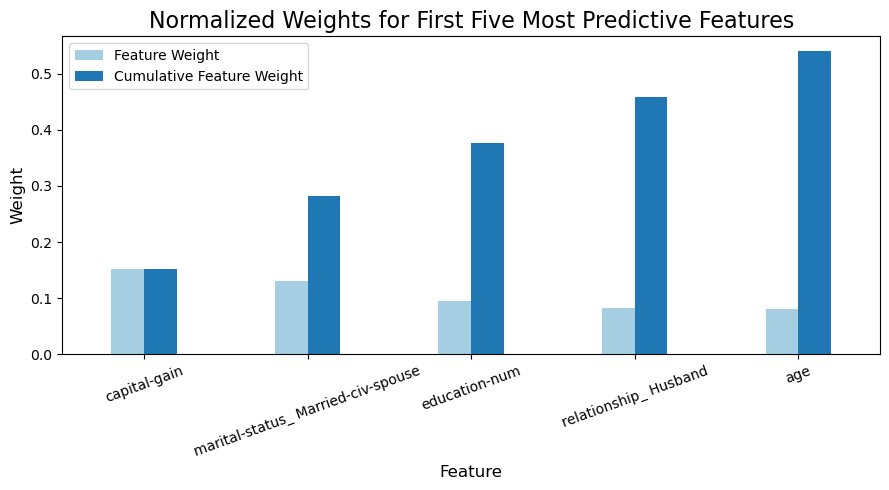

In [12]:
# Import a supervised learning model that has 'feature_importances_'

# Train the supervised model on the training set using .fit(X_train, y_train)
model = best_clf

# Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

The visualization highlights the following five features as most important for predicting whether an individual earns more than $50,000: capital-gain, marital-status_Married-civ-spouse, education-num, age, and relationship_Husband.

In my earlier discussion, I identified education-num, occupation, capital-gain, hours-per-week, and age as the five most important features. Comparing the two lists, there is strong overlap: both my reasoning and the model agree on capital-gain, education-num, and age as critical predictors. This confirms my intuition that financial investments, education level, and work experience are highly correlated with higher income.

Where the model differs is in emphasizing marital-status and relationship instead of occupation or hours worked. This makes sense in the context of census data, where being married (especially “Married-civ-spouse”) or identified as “Husband” correlates strongly with earning above $50,000. These variables may be acting as proxies for social and demographic factors not fully captured by occupation alone.

Overall, the visualization both validates my earlier reasoning and expands it: while I correctly identified education, income-related gains, and age, the model highlights the importance of household and marital context in predicting income, which is a subtle but meaningful insight drawn from the dataset.

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model we found earlier, and train it on the same training set *with only the top five important features*. 

In [13]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.8594
F-score on testing data: 0.7307

Final Model trained on reduced data
------
Accuracy on testing data: 0.8425
F-score on testing data: 0.6870


### Question 8 - Effects of Feature Selection

When the optimized Random Forest model was trained using only the top five features, its performance decreased compared to the full feature set. With all features, the model achieved an accuracy of 0.8605 and an F-score of 0.7337. In contrast, training on only the top five features resulted in a lower accuracy of 0.8422 and an F-score of 0.6865. This shows that while the top five features are highly predictive (capturing more than half of the importance), the remaining features still contribute meaningful information that improves the model’s overall predictive power.

If training time were a critical factor, reducing the feature space could be a worthwhile trade-off. The drop in performance is relatively modest, and the model still achieves strong accuracy and F-scores with significantly less computation. For very large datasets or time-sensitive applications, this approach could be justified. However, given that CharityML’s dataset is not prohibitively large and that the goal is to maximize the correct identification of donors, using the full feature set would be preferable unless computational efficiency becomes a pressing constraint.